In [1]:
import sys
import os
# import from utils folder, add parent directory
sys.path.insert(0, "../utils")
import utils
import train_eval
import network_samples
import numpy as np
import time
import matplotlib.pyplot as plt
import importlib
from tqdm import tqdm
from tqdm import trange
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.datasets import CelebA
from torchvision.utils import save_image

# Assignment 6


#### Experiment 1: Conditional GAN (https://arxiv.org/abs/1411.1784) on FMNIST

#### Experiment 2: Fully convolutional DCGAN (https://arxiv.org/abs/1511.06434) on CelebA

In [2]:
root = "./data"

In [3]:
transform_rgb = T.Compose([
    T.ToTensor(),
    T.Resize((64,64)),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

celeba_train_data = CelebA(root=root, split="all", transform=transform_rgb, download=True)
# celeba_test_data = CelebA(root=root, split="test", transform=transform_rgb, download=True)

BATCH_SIZE = 512

celeba_train_loader = torch.utils.data.DataLoader(celeba_train_data, batch_size=BATCH_SIZE, shuffle=True)
# celeba_test_loader = torch.utils.data.DataLoader(celeba_test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([512, 3, 64, 64])


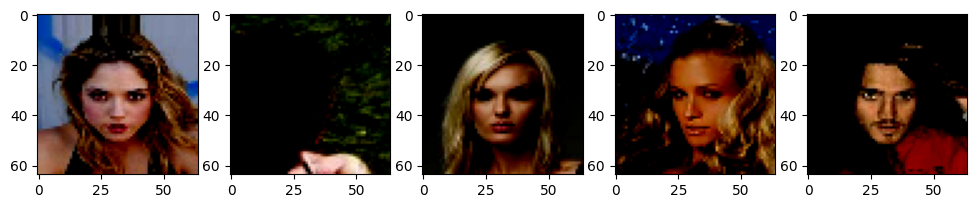

In [4]:
for img, _ in celeba_train_loader:
    print(img.shape)
    plt_nums=5
    _, ax = plt.subplots(1,plt_nums,figsize=(12,6))
    for i in range(plt_nums):
        ax[i].imshow(img[i].permute(1, 2, 0))
    break

In [5]:
# Based on https://www.kaggle.com/code/ashishpatel26/gan-beginner-tutorial-for-pytorch-celeba-dataset

class Generator(nn.Module):
    def __init__(self, latent_dim, num_layers=5, num_channels=3, base_channels=64) -> None:
        super().__init__()
        blocks = []
        for i in range(num_layers - 1):
            ch_in = latent_dim if i == 0 else base_channels * 2 ** (num_layers - 1 - i)
            ch_out = base_channels * 2 ** (num_layers - 2 - i)
            stride = 1 if i == 0 else 2
            pad = 0 if i == 0 else 1
            block_i = network_samples.ConvTransposeBlock(ch_in, ch_out, k_size=4, stride=stride,
                                     pad=pad, batchNorm=True, act_name="relu")
            blocks.append(block_i)

        block_out = network_samples.ConvTransposeBlock(base_channels, num_channels, k_size=4, stride=2,
                                    pad=1, batchNorm=False, act_name="tanh")
        blocks.append(block_out)
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return  self.blocks(x)


class Discriminator(nn.Module):
    def __init__(self, in_channels, out_dim, num_layers=5, base_channels=64, dropout=0.3) -> None:
        super().__init__()
        blocks = []
        for i in range(num_layers - 1):
            ch_in = in_channels if i == 0 else base_channels * 2 ** i
            ch_out = base_channels * 2 ** (i + 1)
            block_i = network_samples.ConvBlock(ch_in, ch_out, kernel_size=4, stride=2, batchNorm=True,
                                     pad=1, act_name="leakyrelu", dropout=dropout)
            blocks.append(block_i)

        block_out = network_samples.ConvBlock(base_channels * 16, out_dim, kernel_size=4, stride=1,
                                    pad=0, batchNorm=False, act_name="sigmoid")
        blocks.append(block_out)
        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)

        

In [6]:
class Trainer:
    def __init__(self, generator, discriminator, latent_dim, tboard, total=0) -> None:
        self.tboard = utils.make_tboard_logs(tboard)
        self.latent_dim = latent_dim
        self.total_ = total
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.gen = generator.to(self.device)
        self.dis = discriminator.to(self.device)
        self.optim_gen = torch.optim.Adam(self.gen.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.optim_dis = torch.optim.Adam(self.dis.parameters(), lr=3e-4, betas=(0.5, 0.9))
        self.criterion_real_dis = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.criterion_fake_dis = lambda pred: F.binary_cross_entropy(pred, torch.zeros(pred.shape[0], device=pred.device))
        self.criterion_gen = lambda pred: F.binary_cross_entropy(pred, torch.ones(pred.shape[0], device=pred.device))
        self.hist = {"dis_real": [], "dis_fake": [], "gen": []}
        return

    def train_step(self, X):
        self.gen.train()
        self.dis.train()
        B = X.shape[0]

        # Train discriminator
        self.optim_dis.zero_grad()
        pred_real = self.dis(X)
        loss_real_dis = self.criterion_real_dis(pred_real.view(B))

        # Initial values of batch samples
        latent = torch.randn(B, self.latent_dim, 1, 1).to(self.device)

        # Generation step
        samples = self.gen(latent)
        pred_fake_dis = self.dis(samples.detach())
        loss_fake_dis = self.criterion_fake_dis(pred_fake_dis.view(B))
        (loss_real_dis + loss_fake_dis).backward()

        assert samples.shape == X.shape

        torch.nn.utils.clip_grad_norm_(self.dis.parameters(), 3.)
        self.optim_dis.step()

        # Train generator
        self.optim_gen.zero_grad()
        pred_fake_gen = self.dis(samples)
        loss_gen = self.criterion_gen(pred_fake_gen.view(B))
        loss_gen.backward()
        self.optim_gen.step()

        return loss_real_dis, loss_fake_dis, loss_gen

    @torch.no_grad()
    def generate(self, N=10):
        self.gen.eval()
        latent = torch.randn(N, self.latent_dim, 1, 1).to(self.device)
        X = self.gen(latent)
        X = X * 0.5 + 0.5
        return X

    def train(self, data_loader, num_iters):
        progress_bar = tqdm(total=num_iters, initial=self.total_)
        running_loss_dis = 0
        running_loss_gen = 0

        with progress_bar as pbar:
            for imgs, _ in data_loader:
                imgs = imgs.to(self.device)
                loss_real_dis, loss_fake_dis, loss_gen = self.train_step(imgs)
                loss_dis = loss_fake_dis + loss_real_dis
                pbar.set_description(f"Iter {self.total_ + 1} || Dis.Loss: {loss_dis.item()} || Gen.Loss: {loss_gen.item()}")
                self.tboard.add_scalar("Dis loss", loss_dis.item(), global_step = self.total_)
                self.tboard.add_scalar("Gen loss", loss_gen.item(), global_step = self.total_)
                self.tboard.add_scalars("Dis losses", {"Real loss": loss_real_dis.item(),
                                                        "Fake loss": loss_fake_dis.item()}, 
                                                        global_step = self.total_)
                self.tboard.add_scalars("Gen/Dis losses", {"Gen loss": loss_gen.item(),
                                                            "Dis loss": loss_dis.item()},
                                                            global_step = self.total_)
                if (self.total_ % 200 == 0):
                    imgs = self.generate()
                    grid = torchvision.utils.make_grid(imgs, nrow=2)
                    self.tboard.add_image("images", grid, global_step=self.total_)
                    torchvision.utils.save_image(grid, os.path.join(os.getcwd(), "imgs", "training", f"imgs_{self.total_}.png"))

                self.total_ += 1

        return


In [7]:
DCGen = Generator(latent_dim=128, num_layers=5, num_channels=3, base_channels=64)
DCDis = Discriminator(in_channels=3, out_dim=1, num_layers=5, base_channels=64, dropout=0.3)
trainer = Trainer(DCGen, DCDis, latent_dim=128, tboard="DCGAN")

/home/user/gomezruizs0/CL/CudaLab_SGR_PS/Session06/tboard_logs/DCGAN


In [8]:
N_iters = 10000
while trainer.total_ < N_iters:
    trainer.train(celeba_train_loader, num_iters=N_iters)

Iter 396 || Dis.Loss: 1.1676690578460693 || Gen.Loss: 6.9207024574279785:   0%|          | 0/10000 [06:16<?, ?it/s]  
Iter 792 || Dis.Loss: 0.5889959335327148 || Gen.Loss: 2.740989923477173:   4%|▍         | 396/10000 [06:18<?, ?it/s]   
Iter 1188 || Dis.Loss: 0.24244992434978485 || Gen.Loss: 12.378235816955566:   8%|▊         | 792/10000 [06:18<?, ?it/s]
Iter 1584 || Dis.Loss: 0.3508210778236389 || Gen.Loss: 3.128187417984009:  12%|█▏        | 1188/10000 [06:17<?, ?it/s]   
Iter 1980 || Dis.Loss: 1.5737690925598145 || Gen.Loss: 3.8971731662750244:  16%|█▌        | 1584/10000 [06:19<?, ?it/s] 
Iter 2376 || Dis.Loss: 0.5906205177307129 || Gen.Loss: 9.56688117980957:  20%|█▉        | 1980/10000 [06:19<?, ?it/s]    
Iter 2772 || Dis.Loss: 0.6332342028617859 || Gen.Loss: 2.8704700469970703:  24%|██▍       | 2376/10000 [06:18<?, ?it/s] 
Iter 3168 || Dis.Loss: 0.3595160245895386 || Gen.Loss: 7.555153846740723:  28%|██▊       | 2772/10000 [06:18<?, ?it/s]   
Iter 3564 || Dis.Loss: 0.773933768

In [14]:
import imageio

images = []
img_path = os.path.join(os.getcwd(), "imgs", "training")

# making list with images and orting by iteration
img_list = [img for img in os.listdir(img_path) if "imgs_" in img]
sorted_imgs = sorted(img_list, key=lambda x: int(x.split("_")[1].split(".")[0]))

for img in sorted_imgs:
    images.append(imageio.imread(os.path.join(img_path, img)))

imageio.mimsave(os.path.join(img_path, "progress.gif"), images, duration=1)


/tmp/ipykernel_2954416/3950469524.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join(img_path, img)))


In [28]:
grid.shape

torch.Size([3, 530, 530])

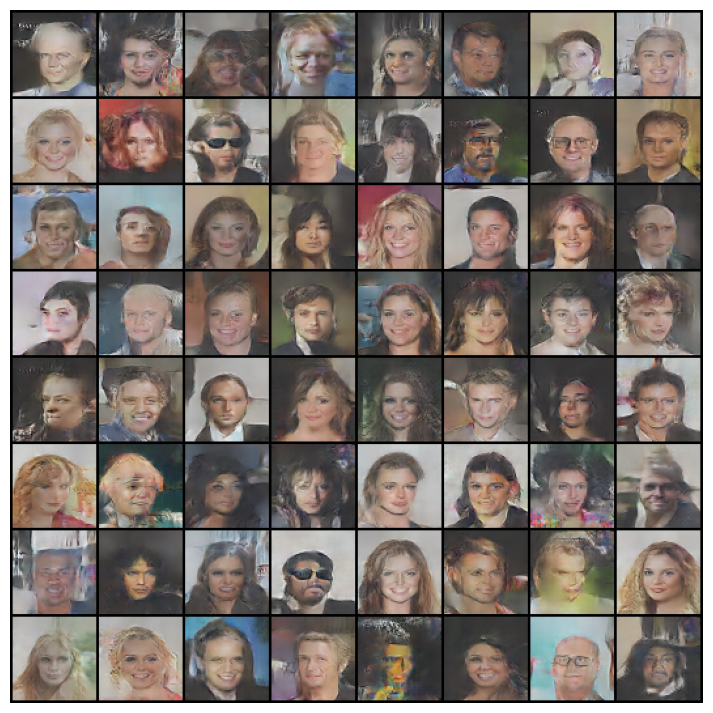

In [31]:
imgs = trainer.generate(N=64)
grid = torchvision.utils.make_grid(imgs, nrow=8)
plt.figure(figsize=(9,9))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()